# Dreamclinic Client Churn

In [30]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import datetime as dt
from sklearn.linear_model import LogisticRegression
from dreamclinic_churn_functions import groupby_time, clean_df, unique_client_agg, sum_client_agg, clean_agg_df, line_plot, session_count_graph
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client_df = pd.read_pickle('client_df.pkl')

In [3]:
clean_client_df = clean_df(client_df)

/Users/flatironschool/dales_work/capstone/dreamclinc_customer_churn/dreamclinic_churn_functions.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['Service_Catagory'] = df['Service_Category'].fillna(value='Massage')
/Users/flatironschool/dales_work/capstone/dreamclinc_customer_churn/dreamclinic_churn_functions.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['Therapist'] = df['Therapist'].str.strip()
/Users/flatironschool/dales_work/capstone/dreamclinc_customer_churn/dreamclinic_churn_functions.py:18: SettingWithCopyWarning: 
A 

In [4]:
g = groupby_time(clean_client_df, offset_alias='M')

In [5]:
client_count_df = unique_client_agg(g)

In [6]:
client_count_df = clean_agg_df(client_count_df)

# Graph of unique client counts per month from August, 2016

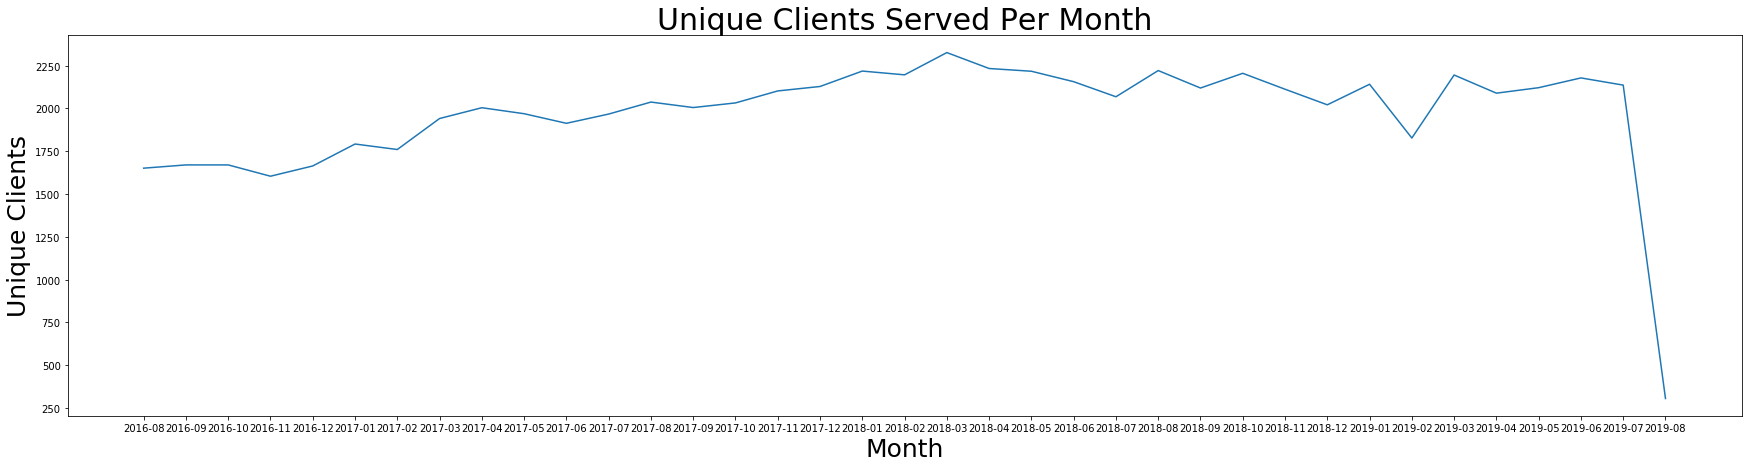

In [8]:
line_plot(client_count_df, 
          'Unique Clients Served Per Month', 
          'Month', 
          'Unique Clients', 
          'client_count')

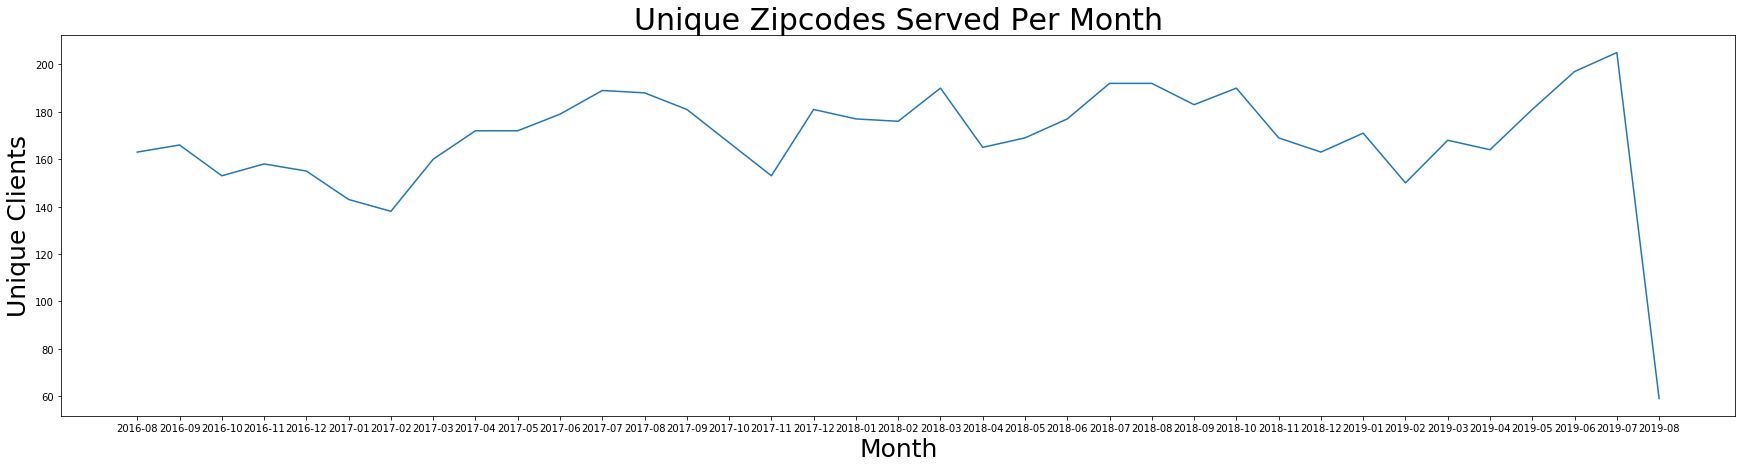

In [7]:
line_plot(client_count_df, 
          'Unique Zipcodes Served Per Month', 
          'Month', 
          'Unique Clients',
          'Address_Zip')

In [17]:
service_given_df = sum_client_agg(g)

In [18]:
service_given_df = clean_agg_df(service_given_df)

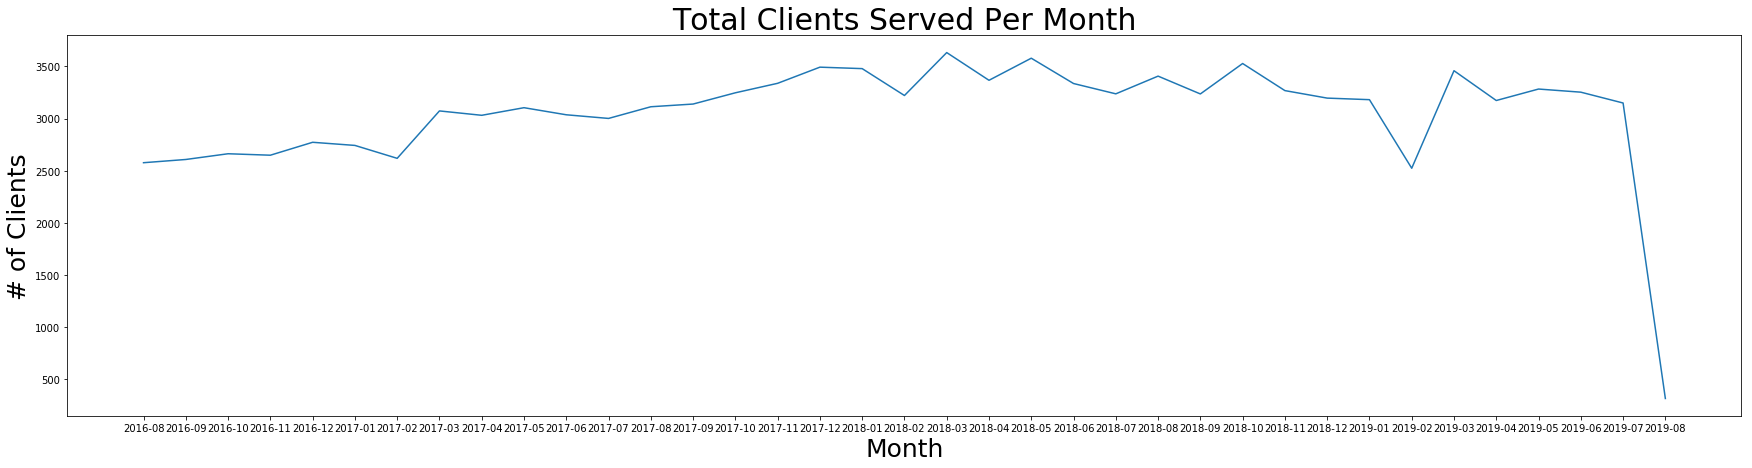

In [24]:
line_plot(service_given_df, 
          'Total Clients Served Per Month', 
          'Month', 
          '# of Clients',
          'Service_Catagory')

The average number of sessions a client recieves is ~5.5.

The highest number of massages received is 175 by the CEO of the company


In [25]:
session_count = client_df.groupby('clientID').nunique()['TransactionDate']

<function matplotlib.pyplot.show(*args, **kw)>

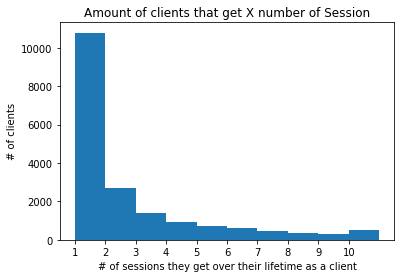

In [36]:
session_count_graph(session_count, 1, 10)

## The average client get 5.5 sessions and sees 2.5 different therapists.
## People tend to get 1.25 hour sessions which is almost split between the 1h and 1.5h offerings we have.

In [37]:
client_df.groupby('clientID').nunique().mean()

TransactionDate     5.462503
clientID            1.000000
Therapist           2.605174
Address_City        0.907621
Address_State       0.907481
Address_Zip         0.898439
Invoice_Category    1.119506
Service_Category    0.887579
HrsWorked           1.375670
dtype: float64

# Mark Clients with Churned or Not Churned for further modeling

In [38]:
def temporal_split(df, start_year=2019, start_month=6, start_day=1, end_year=2019, end_month=8, end_day=1):
    """Needs DataFrame"""
    #cuts the data temporally to the last 2 months so that we can label the data for modeling
    start = client_df['TransactionDate'].searchsorted(dt.datetime(start_year, start_month, start_day))
    end = client_df['TransactionDate'].searchsorted(dt.datetime(end_year, end_month, end_day))

    #DataFrame used as labeling data
    not_churn_df = client_df.iloc[start:end]
    not_churn_df['churn'] = False
    labeling_df = pd.DataFrame(not_churn_df['clientID'].unique())
    labeling_df['churn'] = False
    labeling_df.rename({0 : 'clientID'},axis=1, inplace=True)
    churn_df = client_df.merge(labeling_df, 
                               how='left', 
                               on='clientID')
    churn_df['churn'].fillna(value=True, inplace=True)
    return churn_df

churn_df = temporal_split(client_df)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
churn_df['churn'].fillna(value=True, inplace=True)

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
def temporal_test_split(churn_df, 
                        start_year=2018, 
                        start_month=12, 
                        start_day=1, 
                        end_year=2019, 
                        end_month=5, 
                        end_day=31):
    
    """needs churn_df, outputs temporal test_df for train_test_split"""# Temporal test split
    start = churn_df['TransactionDate'].searchsorted(dt.datetime(start_year, start_month, start_day))
    end = churn_df['TransactionDate'].searchsorted(dt.datetime(end_year, end_month, end_day))
    test_df = churn_df.iloc[start:end]
    return test_df
test_df = temporal_test_split(churn_df)

In [42]:
def temporal_train_split(churn_df, 
                         end_year=2018, 
                         end_month=11, 
                         end_day=30):
    #Temporal train split
    end = churn_df['TransactionDate'].searchsorted(dt.datetime(end_year, end_month, end_day))
    train_df = churn_df.iloc[:end]
    return train_df
train_df = temporal_train_split(churn_df)

In [43]:
train_df.head()

,TransactionDate,clientID,Therapist,Address_City,Address_State,Address_Zip,Invoice_Category,Service_Category,HrsWorked,churn
0,2016-08-02,40156.0,Michael Jacobus,Seattle,Wa,98109,Clinic_Ins,NaN,1.0,True
1,2016-08-02,60005.0,Lauren Anderson,seattle,wa,98119,Clinic_CA,Massage,1.0,False
2,2016-08-02,43420.0,Stefanie Smith,Seattle,WA,98144,Clinic_Ins,NaN,1.0,False
3,2016-08-02,56100.0,Elizabeth Panelo,Seattle,Wa,98203,Clinic_Ins,NaN,1.0,False
4,2016-08-02,57367.0,Daniel Cook,Seattle,WA,98115,Clinic_Ins,NaN,1.0,True


In [44]:
def aggregate(df, unique_col='clientID', to_aggregate=['TransactionDate', 'Therapist', 'Service_Category']):
    aggregated_df = df.groupby(unique_col).nunique()
    aggregated_df = aggregated_df[to_aggregate]
    return aggregated_df

train_agg_df = aggregate(train_df)
test_agg_df = aggregate(test_df)

In [ ]:

# test_df['clientID'].unique()
# weeds_test_df = test_df.groupby('clientID').nunique()
# weeds_test_df = weeds_test_df[['TransactionDate', 
#                                'Therapist', 
#                                'Service_Category']]

In [45]:
churn_df_id_churn = churn_df[['clientID', 
                              'churn']]

In [46]:
# churn or not df for all client IDS, useful for merging
churn_df_id_churn.drop_duplicates(inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
test_merge_df = test_agg_df.merge(churn_df_id_churn, 
                                    how='inner', 
                                    right_on='clientID', 
                                    left_index=True)
test_merge_df.reset_index(inplace=True)
test_merge_df.drop('index', axis=1, inplace=True)

In [48]:
train_merge_df = train_agg_df.merge(churn_df_id_churn, 
                                      how='inner', 
                                      right_on='clientID', 
                                      left_index=True)
train_merge_df.reset_index(inplace=True)
train_merge_df.drop('index', axis=1, inplace=True)
train_target = train_merge_df['churn']

In [49]:
X_train = train_merge_df[['TransactionDate', 'Therapist', 'Service_Category']]
y_train = train_merge_df['churn']
X_test =  test_merge_df[['TransactionDate', 'Therapist', 'Service_Category']]
y_test = test_merge_df['churn']

In [50]:
log_reg = LogisticRegression()

In [51]:
log_reg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [52]:
# first model is barely better then just guessing the mean
log_reg.score(X_test, y_test)

0.6817050404480398

In [53]:
y_test.mean()

0.6810827629122589

In [54]:
X_prob = log_reg.predict_proba(X_test)[:, -1]

In [55]:
from sklearn.metrics import roc_auc_score, roc_curve

In [56]:
roc_auc_score(y_test, [y_test.mean()]*len(y_test))

0.5

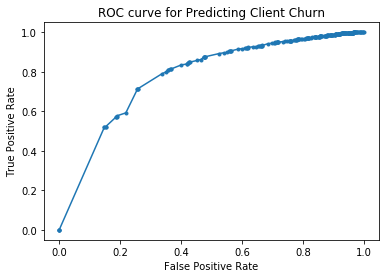

In [57]:
fpr, tpr, thresholds = roc_curve(y_test, X_prob)
plt.plot(fpr, tpr, marker='.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Predicting Client Churn")
plt.show();

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, X_prob)

In [ ]:
log_reg.coef_


In [ ]:
log_reg.predict_proba(X_test)

In [ ]:
# False = client keeps coming to the clinics

In [ ]:
ten_or_more_ids = session_count[session_count > 9]
ten_or_more_ids = four_or_more_ids.T
client_history_10_more_df = client_df.merge(four_or_more_ids, how='right', left_on='clientID', right_index=True)
client_history_10_more_df.reset_index(inplace=True)

In [ ]:
client_history_10_more_df

In [ ]:
ten_or_more_ids = session_count[session_count > 9]
ten_or_more_ids = pd.DataFrame([ten_or_more_ids])
ten_or_more_ids = ten_or_more_ids.T

In [ ]:
client_history_10_more_df = client_df.merge(ten_or_more_ids, how='right', left_on='clientID', right_index=True)
client_history_10_more_df.reset_index(inplace=True)

In [ ]:
client_history_10_more_df.drop('index', axis=1, inplace=True)

In [ ]:
client_history_10_more_df.rename({'TransactionDate_y' : 'session_count', 'TransactionDate_x' : "date"}, axis=1, inplace=True)

In [ ]:
client_history_10_more_df['since_last'] = None

In [ ]:
# finds interval lengths for clients who have been in at least 10 times,  O(n) time O(n) space
interval = []
for i in range(0, len(client_history_10_more_df)):
    if client_history_10_more_df.iloc[i]['clientID'] == id:
        diff = client_history_10_more_df.iloc[i]['date'] - client_history_10_more_df.iloc[i-1]['date']
        interval.append(diff)
    else:
        id = client_history_10_more_df.iloc[i]['clientID']
        interval.append(0)

client_history_10_more_df['since_last'] = interval

In [ ]:
client_history_10_more_df

In [ ]:
client_history_10_more_df['since_last'][0].days

In [ ]:
def extract_day(x):
    """extract day from the element."""
    if isinstance(x, int):
        return x
    else:
        return x.days

In [ ]:
client_history_10_more_df["clean_since_last"] = client_history_10_more_df['since_last'].apply(extract_day)

In [ ]:
client_history_10_more_df

In [ ]:
grouped_df = client_history_10_more_df.groupby('clientID')['clean_since_last'].mean()

In [ ]:
sns.violinplot(grouped_df)
plt.xlabel('Average time between visits in days')
plt.title('Frequency that Clients get a massage');

In [ ]:
first_time_df = pd.DataFrame(client_df.groupby('clientID')['TransactionDate'].min())

In [ ]:
first_time_df['month'] = first_time_df['TransactionDate'].dt.month

In [ ]:
first_time_df['year'] = first_time_df['TransactionDate'].dt.year

In [ ]:
count_first_time_by_month_df = first_time_df.groupby(['year', 'month']).count()

In [ ]:
count_first_time_by_month_df.reset_index(inplace=True)

In [ ]:
count_first_time_by_month_df

In [ ]:
count_first_time_by_month_df.drop('time', axis=1, inplace=True)

In [ ]:
count_first_time_by_month_df['datetime']= pd.to_datetime(count_first_time_by_month_df['year'].astype(str) + count_first_time_by_month_df['month'].astype(str), format='%Y%m')

In [ ]:


fig, ax = plt.subplots(figsize=(30,7))

sns.lineplot(count_first_time_by_month_df['datetime'], count_first_time_by_month_df['TransactionDate'])
plt.xlabel('Month')
plt.ylabel('# of new clients')
plt.title("New clients by month for the last 3 years");

In [ ]:
churn_df.churn.value_counts()

In [ ]:
churn_df_id_churn.churn.value_counts()

In [ ]:
from sklearn.utils import resample

In [ ]:
resample.